In [1]:
%matplotlib inline

# Linear Regression Review

if you didn't have a chance yet, you should check out the following concepts related to _linear regression_ :


## code review

if you want a brief review of implementing linear regression in python, see:

[writeup of doing linear regression in python](https://www.cs.toronto.edu/~frossard/post/linear_regression/)

[my class-based python implementation for study group](https://github.com/SNUDerek/MLPy/blob/master/mlpy/regression/linear_regression.py)


## gradient descent methods

worth to know since this is the idea that powers a lot of machine learning

[conceptual introduction](https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html)


## gradient descent vs stochastic & minibatch gradient descent

gradient descent updates weights after averaging the error of _all_ the data in the training set. 

instead, we can make an update after each example ('pure' stochastic GD) or after looking at just a few examples (mini-batch).

as we make updates on fewer examples, we get to update our parameters more frequently = faster learning, but we get more noise, which can affect the minimum that we settle in. there is a lot more to it, of course.

[brief conceptual introduction](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/)

[good code example discussing GD vs SGD](https://www.pyimagesearch.com/2016/10/17/stochastic-gradient-descent-sgd-with-python/)


## multivariate gradient descent

as mentioned, we can ahve multiple inputs to our model 

(e.g. for predicting housing prices, maybe we have # of rooms, # of bedrooms/bathrooms, total floor space, stories, etc)

so this would be : `y = w_1 * x_1 + w_2 + x_2 + w_3 + x_3 ... + b`

[linear regression with SGD in python](https://machinelearningmastery.com/implement-linear-regression-stochastic-gradient-descent-scratch-python/)


## polynomial regression

a type of multivariate model where each feature is an nth-order polynomial of a feature x:

`y = w_1 * x + w_2 + x^2 + w_3 + x^3 ... + b`

this allows us to fit a curve to non-linear (polynomial) data.

[Wikipedia](https://en.wikipedia.org/wiki/Polynomial_regression)

https://github.com/SNUDerek/MLPy/blob/master/mlpy/regression/linear_regression.py


## regularization

this helps prevent the model from overfitting by introducing a 'penalty' to our weight updates, preventing any weight from growing too 'strong'. more easy to conceptualize in multivariate models, or polynomial models (_see above), where the regularization 'smooths out' the function.

[Andrew Ng video lesson on regularization](https://www.youtube.com/watch?v=qbvRdrd0yJ8)

[Analytics Vidhya: see section on Ridge (L2) Regression](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)



##############################################################################################################################3

# Logistic Regression

Whereas linear regression sought to find a function that approximated a series of continuous values (e.g. price, speed, volume, signal strength, mass, etc.), logistic regression seeks to find a function that can discriminate (categorize) between two classes. it seeks to find weights that divide the data into two: negative values fall into class zero, and positive values would be classified into class one. the 'ideal' would be a step function:

![step function](http://www.gnuplotting.org/figs/step.png)

...but this isn't differentiable, so we can approximate this with a sigmoid, or logistic function:

![sigmoid function](https://sebastianraschka.com/images/faq/logisticregr-neuralnet/sigmoid.png)

if you recall your exponents, you can see how this function works. as the denominator of the main expression gets smaller (towards 1), then the fraction's value approaches 1. as the denominator gets larger and larger, the fraction becomes `1/999999999~` etc., approaching zero.

a negative exponent is like an inverse: `x^-a = 1/x^a`. so:

- as the _z_ in that image gets larger...
- the `e^-z` gets smaller and smaller. 
- so `1 + e^-z` approaches `1 + 0.00001 ~= 1`...
- which means `1/(1 + 0.00001) ~= 1`
- therefore, as _z_ approaches infinity, sigmoid(z) approaches 1/1 = 1

in the other direction, we can see it approaches zero:

- as _z_ gets more negative...
- negative times negative = positive...
- so exponent on `e` is getting more and more positive (larger)
- so `1 + e^-z` is approaching `1 + 10000000... = infinity`
- so `1 / (very large number) = very small number` = zero
- therefore, as _z_ approaches negative infinity, sigmoid(z) approaches 1/1000000 = 0

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

(-0.5792838868948917,
 8.810105847722037,
 -0.6270867116642176,
 9.117492051434196)

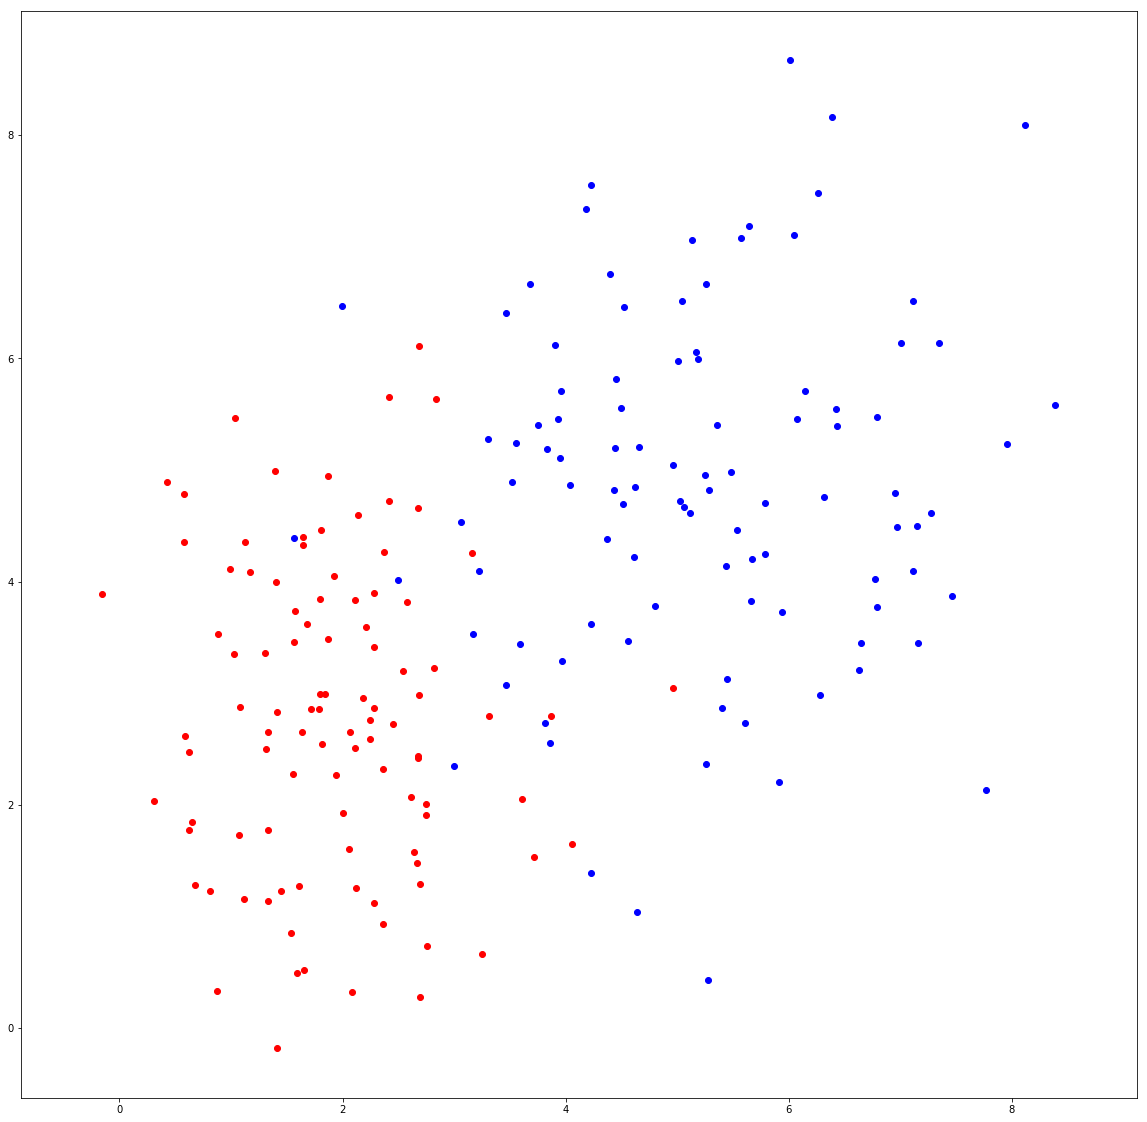

In [3]:
# fix seed for reproducibility
np.random.seed(123)
samples = 100

# generate two classes of data by sampling from two distributions.
# this is multivariate, so it will generate two features.

# class one: normal distribution with mean 5, 5
f1a, f2a = np.random.multivariate_normal([5,5], [[2, 0], [0, 2]], samples).T
ya = np.ones(samples) # label: 1

# class one: normal distribution with mean 2, 3
f1b, f2b = np.random.multivariate_normal([2,3], [[1, 0], [0, 2]], samples).T
yb = np.zeros(samples) # label: 0

# plot data for viz
plt.figure(figsize=(20, 20))
plt.plot(f1a, f2a, 'bo')
plt.plot(f1b, f2b, 'ro')
plt.axis('equal')

here the _x_ and _y_ terms of the graph are actually representing two _x features_, and the _color_ (blue/red) represents the 'y' class value.

for example, _vertical axis_ and _horizontal axis_ might correlate _height_ and _endurance_, and binary feature _y_ represents 'qualified for basketball team'.

( _we are assuming a lot, for example that everyone in our sample_ tried out _for the team, to limit confounding factors_ )

while there are some tall, weaker players that play (the blue dots near the bottom), and shorted, powerful guys (blue dots on the left, but high up), most basketball players have higher

In [4]:
# join data together into complete dataset
f1 = np.concatenate((f1a, f1b))
f2 = np.concatenate((f2a, f2b))
# this stacks them into (x1_i, x2_i) tuples
f1 = f1[:, np.newaxis]
f2 = f2[:, np.newaxis]
X = np.hstack((f1, f2))
# and join the y's up too
y = np.concatenate((ya, yb))

# shuffle data
shuffle_idx = np.random.permutation(X.shape[0])
X = X[shuffle_idx]
y = y[shuffle_idx]

X.shape

(200, 2)

# logistic regression

we will borrow the same main loop as before, but make the following big changes:
- adjust math for multivariate input
- adjust cost function and gradient : from sum of squares error to negative log-likelihood (bc different task)
- put some tasks into subfunctions for readability

### sigmoid function

a function that calculates the sigmoid of a value using the expression on the graph above

whereas the linear regression values were continuous values, the sigmoid function smashes

In [5]:
# sigmoid function
def sigmoid(estimates):

    sig = 1 / (1 + np.exp(-estimates))

    return sig

### cost function: negative log-likelihood

unlike the sum-of-squares error, which had a very easy visualization, log-likelihood is a little harder to grasp immediately.

the takeaway we need to consider here is the _gradient_, which we need for _gradient descent_

of course there are a million different representations due to minus signs and stuff. for clarity let's use the Stanford pattern.

simple overview w/gradient: [Stanford Logistic Regression Handout](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/pdfs/40%20LogisticRegression.pdf)

just the derivation, please: [Maths StackExchange Derivation](https://math.stackexchange.com/questions/477207/derivative-of-cost-function-for-logistic-regression)

and a video for the lazy: [Coursera Supplementary Video](https://www.coursera.org/learn/ml-classification/lecture/W3VBS/very-optional-deriving-gradient-of-log-likelihood)

simple ML-based explanation: [_ML notes: Why the log-likelihood?_](https://blog.metaflow.fr/ml-notes-why-the-log-likelihood-24f7b6c40f83)

stats-based description: [_Minimizing the Negative Log-Likelihood, in English_](http://willwolf.io/2017/05/18/minimizing_the_negative_log_likelihood_in_english/) ( _caution: may explode heads_ )

In [6]:
# internal function for making hypothesis and getting cost
def costfunction(x_data, y_hat, y_data, weights):

    # get the difference between the true and hypothesis
    difference =  y_data.flatten() - y_hat 
    
    # gradient is sum of x_i times difference_i = dot product
    # notice we don't need actual cost function here
    # it's negative because NEGATIVE LOG LIKELIHOOD is our cost
    gradient = -np.dot(x_data.T, difference)

    return gradient

### gradient descent iterative loop

basic gradient descent review:

- initialize our weights + biases

while not converged:

1. make a prediction with our current weights
2. measure how off we were (_cost_)
3. find slope of cost function (_gradient_...)
4. take a step 'down the hill' of cost (..._descent_)
5. update weights accordingly


In [7]:
def fit(x_data, y_data, lr=0.01, epochs=100, tol=1e-5, print_iters=10, verbose=False):

    costs = []

    # STEP 1: ADD X_0 TERM FOR BIAS
    # add an 'x0' = 1.0 to our x data so we can treat intercept as a weight
    # use numpy.hstack (horizontal stack) to add a column of ones:
    x_data = np.hstack((np.ones((x_data.shape[0], 1)), x_data))

    # STEP 2: INIT WEIGHT COEFFICIENTS
    # one weight per feature (+ intercept)
    # you can init the weights randomly:
    weights = np.random.randn(x_data.shape[1])
    # or you can use zeroes with np.zeros():
    # weights = np.zeros(x_data.shape[1])

    iters = 0

    # OPTIMIZE
    for epoch in range(epochs):

        # get hypothesis 'scores' (features by weights)
        scores = x_data.dot(weights).flatten()
        # squash these scores thru sigmoid for predictions (0~1)
        y_hat = sigmoid(scores)
        
        # GRADIENT DESCENT:
        # get gradient over ~all~ training instances each iteration
        gradient = costfunction(x_data, y_hat, y_data, weights)

        # calculate actual cost function J (log-likelihood) too
        # loglik = sum y_i theta.T x_i - log( 1 + e^b.T x_i )
        nloglik = -np.sum(y_data*scores - np.log(1 + np.exp(scores)))
        
        # STOCHASTIC (minibatch) GRADIENT DESCENT
        # ~add your own doce here :) ~

        # get new predicted weights by stepping "backwards' along gradient
        # ~add regularization here ~
        new_weights = weights - gradient * lr

        # check stopping condition
        if np.sum(abs(new_weights - weights)) < tol:
            if verbose:
                print("converged after {0} iterations".format(iters))
            break

        # update weight values, save cost
        weights = new_weights
        costs.append(nloglik)
        iters += 1

        # print diagnostics
        if verbose and iters % print_iters == 0:
            print("iteration {0}: cost: {1}".format(iters, nloglik))

    return weights, costs


# fitting a model and plotting the cost

In [8]:
final_weights, final_costs = fit(X, y, lr=0.005, epochs=100, tol=1e-5, print_iters=10, verbose=True)

iteration 10: cost: 157.70212027494648
iteration 20: cost: 121.17488655598095
iteration 30: cost: 98.30639407707152
iteration 40: cost: 83.18336995997942
iteration 50: cost: 67.00862748290497
iteration 60: cost: 53.302353997061374
iteration 70: cost: 43.354081288262776
iteration 80: cost: 37.460334251470215
iteration 90: cost: 34.5786171796125
iteration 100: cost: 33.457056001493754


In [9]:
final_weights

array([-6.98354075,  1.64349912,  0.48813291])

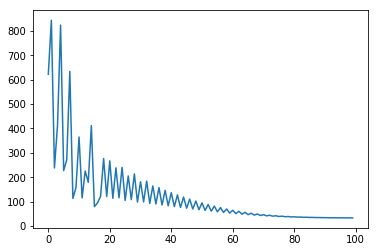

In [10]:
plt.plot(final_costs)

# using our weights to make predictions

using our fitted weights, we can then predict the outcomes but multiplying weights times inputs and sigmoid-ing (and rounding).

we will break the prediction step into two functions because we need the model 'confidence' (prediction probabilities) for graphing, below.

In [11]:
# predict probas on the test data
# inputs : x data as np.array
# outputs : y probabilities as list
def predict_proba(x_data, weights):

    # STEP 1: ADD X_0 TERM FOR BIAS
    x_data = np.hstack((np.ones((x_data.shape[0], 1)), x_data))

    # STEP 2: PREDICT USING THE y_hat EQN
    scores = x_data.dot(weights).flatten()
    y_hat = sigmoid(scores)

    return y_hat

# predict on the test data
# inputs : x data as np.array
# outputs : y preds as list
def predict(x_data, weights):

    y_hat = predict_proba(x_data, weights)

    # ROUND TO 0, 1
    preds = []
    for p in y_hat:
        if p > 0.5:
            preds.append(1.0)
        else:
            preds.append(0.0)

    return np.array(preds)

In [12]:
# get the predicted labels, given our X data and fitted weights
y_preds = predict(X, final_weights)

In [13]:
y_probs = predict_proba(X, final_weights)

In [14]:
y_preds

array([1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.])

In [15]:
# calculate accuracy
def get_accuracy(trues, preds):
    trues = list(trues)
    preds = list(preds)
    assert (len(trues)==len(preds))
    matches = 0
    for i, p in enumerate(preds):
        if p == trues[i]:
            matches += 1
    return matches*100/len(trues)

In [16]:
get_accuracy(y, y_preds)

94.5

## plotting decision boundary

because this is a linear model, the decision boundary will be linear. this boundary partitions the space into areas to which each class 'belongs'

https://stackoverflow.com/questions/20045994/how-do-i-plot-the-decision-boundary-of-a-regression-using-matplotlib

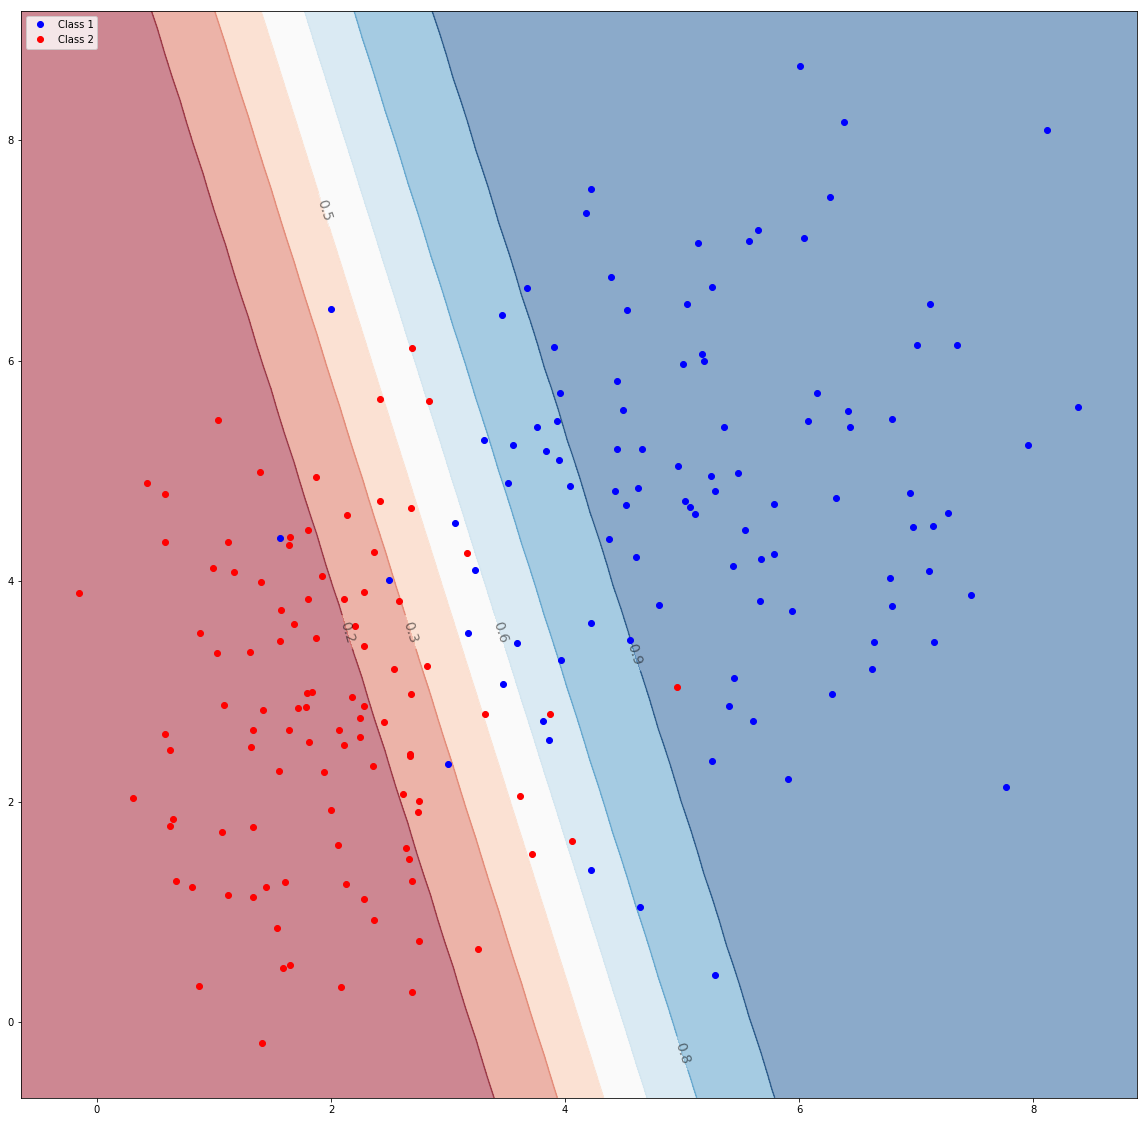

In [17]:
# resize
plt.figure(figsize=(20, 20))

# evenly sampled points
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                     np.linspace(y_min, y_max, 50))
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

#plot background colors
ax = plt.gca()
Z = predict_proba(np.c_[xx.ravel(), yy.ravel()], final_weights)
Z = Z.reshape(xx.shape)
cs = ax.contourf(xx, yy, Z, cmap='RdBu', alpha=.5)
cs2 = ax.contour(xx, yy, Z, cmap='RdBu', alpha=.5)
plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)

# plot points
ax.plot(f1a, f2a, 'bo', label='Class 1')
ax.plot(f1b, f2b, 'ro', label='Class 2')

# make legend
plt.legend(loc='upper left', scatterpoints=1, numpoints=1)

# resources

implementations with walkthrough:  
[Some Deep Learning with Python, TensorFlow and Keras: 1. Linear models, Optimization](https://sandipanweb.wordpress.com/2017/11/25/some-deep-learning-with-python-tensorflow-and-keras/)  
[Logistic Regression from Scratch in Python](https://beckernick.github.io/logistic-regression-from-scratch/)  
[Machine Learning with Python - Logistic Regression](http://aimotion.blogspot.kr/2011/11/machine-learning-with-python-logistic.html)  